## generate image with random PWM values

C:\Users\plasma\AppData\Local\Temp\ipykernel_9932\2668042787.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[pwms], [0], [0], [0], [0]]).astype(int)


The original PWM randomly set by [2738, 0, 0, 0, 0].


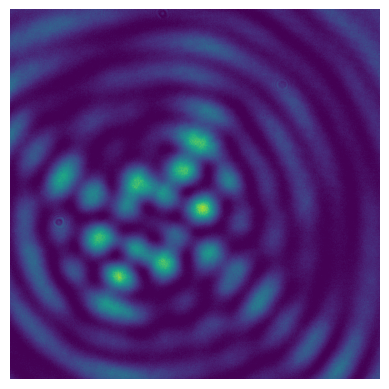

In [1]:
import csv
import numpy as np
import random
import time
from PIL import Image
from imageio import imwrite,imread
import os
from pylablib.devices import Thorlabs
from PIL import Image
import PIL.ImageOps 
import matplotlib.pyplot as plt 
  
from pylablib.devices import Thorlabs
Thorlabs.list_cameras_tlcam()
cam = Thorlabs.ThorlabsTLCamera(serial="14308")
cam.set_exposure(0.0001) # set exposure to 100ms
cam.set_roi(0,1000,0,1000) # set ROI in the upper left corner

import laserbeamsize as lbs
pwms = np.random.randint(low=0,high=4095,size=(1,1), dtype=np.int32)  
A = np.array([[pwms], [0], [0], [0], [0]]).astype(int)
with open('PWM_test.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(A)
raw_image_array = cam.grab(10) # grab 10 frames
image_array_initial=np.array(raw_image_array)
squeezed_image_array=image_array_initial.squeeze()
random_PWM=A
random_PWM_printed=A.ravel().tolist()
print(f"The original PWM randomly set by {random_PWM_printed}.")
plt.axis('off')
plt.imshow(image_array_initial[0])
cam.close()


In [2]:
from scipy import stats
from scipy import optimize
from sklearn.metrics import r2_score
from PIL import Image
import glob
import math
from skimage.filters import sobel

def get_quality_number(squeezed_image_array):
    Score = np.array([])  # Create an empty NumPy array
    for i in range(len(squeezed_image_array)):
        [x_max, y_max] = np.unravel_index(np.argmax(squeezed_image_array[i]), squeezed_image_array[i].shape)
        [m, n] = np.where(squeezed_image_array[i] == round(np.max(squeezed_image_array[i]) / math.exp(1)))
        length = np.sqrt(np.power(abs(m - x_max), 2) + np.power(abs(n - y_max), 2))
        Score = np.append(Score, np.mean(length) / np.max(length))  # Append values to the NumPy array

    return np.mean(Score)  # Calculate the mean of the Score array

# Test your function

s1 = get_quality_number(squeezed_image_array)
print(s1)


0.41388363180978704


In [3]:
def set_PWMs(pwms):
    # Your code that sets the PWMs
    A = np.array([[pwms[0]], [0], [0], [0], [0]]).astype(int)
    with open('PWM_test.csv', 'w', newline='') as file:
        mywriter = csv.writer(file, delimiter=',')
        mywriter.writerows(A)
    return 0

In [4]:
from scipy import stats
from scipy import optimize
from sklearn.metrics import r2_score
from PIL import Image
import glob
from pylablib.devices import Thorlabs
Thorlabs.list_cameras_tlcam()
cam = Thorlabs.ThorlabsTLCamera(serial="14308")
# cam.close()
cam.set_exposure(0.0001) # set exposure to 100ms
# frame = cam.snap() # grab a single frame
cam.set_roi(0,1000,0,1000) # set ROI in the upper left corner

(0, 1000, 0, 1000, 1, 1)

In [5]:
def do_annealing(wait=5*33*0.03):
    # Annealing
    with open('PWM_test.csv', 'r', encoding='utf-8') as pwm_file:
        pwm_data = pwm_file.readlines()
    # Write data to do_annealing.csv
    with open('do_annealing.csv', 'w', encoding='utf-8') as annealing_file:
        annealing_file.writelines(pwm_data)
    time.sleep(wait) # Wait for annealing to complete

In [6]:
def get_quality_number1():

    #take image and calculate the quality number
    raw_image_array = cam.grab(10)    # grab 10 frame
    image_array=np.array(raw_image_array)
    squeezed_image_array=image_array.squeeze()
    score=[]
    for i in range (len(squeezed_image_array)):
        [x_max,y_max] = np.unravel_index(np.argmax(squeezed_image_array[i]), squeezed_image_array[i].shape) 
        [m,n]=np.where(squeezed_image_array[i]==round(np.max(squeezed_image_array[i])/math.exp(1)))
        length = np.sqrt(np.power(abs(m-x_max),2)+np.power(abs(n-y_max),2))
        score.append(np.mean(length)/np.max(length))
    average_score=np.mean(score)
    quality_number = average_score
    return quality_number

In [7]:
# SYNTHESIS and CHARACTERISATION
from OptimizationTestFunctions import Sphere, plot_3d
def set_PWMs_and_get_quality(pwms,sphere_test=False, annealing=False):
    if sphere_test:
        f = Sphere(dim=5,degree=2)
        #return -1*f(pwms)
        return -1*f(pwms)/1000000
    else:
        set_PWMs(pwms)
        quality_number = get_quality_number1()
        if annealing:
            do_annealing()
        return quality_number

In [8]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize

In [9]:
# Random Strategy

import random

def get_random_PWMs():
    return [random.randint(0, 4095) for _ in range(5)]

random_PWMs = get_random_PWMs()
print(random_PWMs)

[1467, 3968, 309, 954, 304]


In [10]:
# Bayesian Opt Strategy

import numpy as np
import pandas as pd

from botorch.acquisition import qExpectedImprovement
from botorch.sampling import SobolQMCNormalSampler

sampler = SobolQMCNormalSampler(sample_shape=torch.Size([512]), seed=0)
torch.manual_seed(seed=0)  # to keep the restart conditions the same    

def calculate_BO_candidate(samples):
    train_X = samples[["p1","p2","p3","p4","p5"]]
    train_Y = samples[["error"]]

    train_X = torch.tensor(train_X.to_numpy(dtype=np.float64))
    train_Y = torch.tensor(train_Y.to_numpy(dtype=np.float64))

    gp = SingleTaskGP(train_X, train_Y, input_transform=Normalize(d=train_X.shape[-1]), outcome_transform=Standardize(m=train_Y.shape[-1]),)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)

    #from botorch.acquisition import UpperConfidenceBound
    #UCB = UpperConfidenceBound(gp, beta=.1)

    MC_EI = qExpectedImprovement(gp, best_f=train_Y.max(), sampler=sampler)
    
    
    from botorch.optim import optimize_acqf
    bounds = torch.stack([torch.zeros(5), torch.ones(5)*4095])
    #bounds = torch.stack([torch.zeros(5), torch.ones(5)*5])

    candidate, acq_value = optimize_acqf(
        MC_EI, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
    )
    candidate = candidate[0]
    return candidate

Optimisation Loop:

In [11]:
import random
import pandas as pd
import time

N_TRIALS = 15
N_ITERATIONS = 250
USE_TEST_FUNCTION = False

best_random_all = []
best_BO_all = []
random_trial_samples = []
BO_trial_samples = []



for trial in range(N_TRIALS):
    print(f"Trial {trial}")
    BO_samples = pd.DataFrame(columns=['p1', 'p2', 'p3', "p4", "p5", 'error', 'trial', "iteration", "timestamp"])
    random_samples = pd.DataFrame(columns=['p1', 'p2', 'p3', "p4", "p5", 'error', 'trial', "iteration", "timestamp"])
    BO_current_candidate = get_random_PWMs()
    random_current_candidate = get_random_PWMs()
    
    best_random = []
    best_BO = []

    for iteration in range(N_ITERATIONS):
        
        #print(f"Iteration {iteration}")
        # Random Search
        random_current_quality = set_PWMs_and_get_quality(random_current_candidate, sphere_test=USE_TEST_FUNCTION)
        new_sample = {f"p{i+1}": p for i, p in enumerate(random_current_candidate)}
        new_sample["error"] = random_current_quality
        new_sample["timestamp"] = time.time()
        new_sample["trial"] = trial
        new_sample["iteration"] = iteration
        new_sample = pd.DataFrame(new_sample, index=[iteration])
        random_samples = pd.concat([random_samples, new_sample], axis=0, ignore_index=True)
        random_current_candidate = get_random_PWMs()
        
        # Bayesian Optimization
        BO_current_quality = set_PWMs_and_get_quality(BO_current_candidate, sphere_test=USE_TEST_FUNCTION)
        new_sample = {f"p{i+1}": p for i, p in enumerate(BO_current_candidate)}
        new_sample["error"] = BO_current_quality
        new_sample["timestamp"] = time.time()
        new_sample["trial"] = trial
        new_sample["iteration"] = iteration
        new_sample = pd.DataFrame(new_sample, index=[iteration])
        BO_samples = pd.concat([BO_samples, new_sample], axis=0, ignore_index=True)
        
        if iteration < 10:
            BO_current_candidate = get_random_PWMs()
        else:
            BO_current_candidate = calculate_BO_candidate(BO_samples)
            BO_current_candidate = [torch.round(x) for x in BO_current_candidate]
        
        best_random.append(random_samples["error"].max())
        best_BO.append(BO_samples["error"].max())
        
    random_trial_samples.append(random_samples.copy(deep=True))
    BO_trial_samples.append(BO_samples.copy(deep=True))
    
    best_random_all.append(best_random)
    best_BO_all.append(best_BO)

    # Print the best BO parameters and value for the current trial
    best_BO_value = max(best_BO)
    best_BO_index = best_BO.index(best_BO_value)
    best_BO_params = BO_trial_samples[trial].loc[best_BO_index, ['p1', 'p2', 'p3', 'p4', 'p5']].tolist()
    print(f"Best BO Parameters (Trial {trial}):", best_BO_params)
    print(f"Best BO Value (Trial {trial}):", best_BO_value)
    print("=" * 30)
import pickle
# open a file, where you ant to store the data
filename = 'results_'+str(time.time())
file = open(filename, 'wb')

# dump information to that file
data = (random_trial_samples, BO_trial_samples, best_random_all, best_BO_all)
pickle.dump(data, file)
# close the file
file.close()



Trial 0


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\optimize.py:359: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\optimize.py:359: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acqui

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

Best BO Parameters (Trial 0): [tensor(462.), tensor(614.), tensor(2076.), tensor(82.), tensor(1823.)]
Best BO Value (Trial 0): 0.6957110300297541
Trial 1


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

Best BO Parameters (Trial 1): [2707, 2676, 3252, 1519, 1369]
Best BO Value (Trial 1): 0.6849721929060049
Trial 2


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Best BO Parameters (Trial 2): [tensor(2428.), tensor(867.), tensor(3337.), tensor(3202.), tensor(651.)]
Best BO Value (Trial 2): 0.6906624103739655
Trial 3


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

Best BO Parameters (Trial 3): [tensor(58.), tensor(2490.), tensor(3552.), tensor(381.), tensor(781.)]
Best BO Value (Trial 3): 0.6871890891439857
Trial 4


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

Best BO Parameters (Trial 4): [tensor(2133.), tensor(2297.), tensor(1224.), tensor(1755.), tensor(2972.)]
Best BO Value (Trial 4): 0.6881001748570684
Trial 5


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

Best BO Parameters (Trial 5): [tensor(3162.), tensor(2080.), tensor(3407.), tensor(938.), tensor(1242.)]
Best BO Value (Trial 5): 0.6807977422442287
Trial 6


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

Best BO Parameters (Trial 6): [tensor(2493.), tensor(1863.), tensor(478.), tensor(2188.), tensor(701.)]
Best BO Value (Trial 6): 0.6860482372188902
Trial 7


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\optimize.py:359: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializ

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Best BO Parameters (Trial 7): [tensor(1732.), tensor(3436.), tensor(2408.), tensor(3725.), tensor(940.)]
Best BO Value (Trial 7): 0.6883296743780871
Trial 8


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

Best BO Parameters (Trial 8): [tensor(3723.), tensor(3299.), tensor(2344.), tensor(2320.), tensor(3962.)]
Best BO Value (Trial 8): 0.688948097961325
Trial 9


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

Best BO Parameters (Trial 9): [tensor(3891.), tensor(1143.), tensor(155.), tensor(2117.), tensor(3489.)]
Best BO Value (Trial 9): 0.6940745520784166
Trial 10


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

Best BO Parameters (Trial 10): [tensor(1378.), tensor(980.), tensor(1168.), tensor(3813.), tensor(2661.)]
Best BO Value (Trial 10): 0.6917144683389627
Trial 11


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Best BO Parameters (Trial 11): [tensor(1485.), tensor(1985.), tensor(84.), tensor(4066.), tensor(2214.)]
Best BO Value (Trial 11): 0.6881920242665741
Trial 12


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

Best BO Parameters (Trial 12): [tensor(1612.), tensor(1093.), tensor(1445.), tensor(3743.), tensor(3210.)]
Best BO Value (Trial 12): 0.6864105175637125
Trial 13


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

Best BO Parameters (Trial 13): [tensor(3254.), tensor(4083.), tensor(4079.), tensor(1968.), tensor(2284.)]
Best BO Value (Trial 13): 0.6883229485107432
Trial 14


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

Best BO Parameters (Trial 14): [tensor(2197.), tensor(2250.), tensor(406.), tensor(3058.), tensor(1386.)]
Best BO Value (Trial 14): 0.6887595738315464


In [12]:
BO_trial_samples

[                p1             p2             p3             p4  \
 0             1124            923            317           1094   
 1             3066           3978           3233           3205   
 2              125           2471           2025           3639   
 3              259           2698           2500            501   
 4             2911           3361           2789            627   
 ..             ...            ...            ...            ...   
 245  tensor(1251.)  tensor(1171.)  tensor(2488.)   tensor(554.)   
 246  tensor(2010.)  tensor(4079.)  tensor(2835.)  tensor(1800.)   
 247  tensor(2532.)   tensor(718.)  tensor(3835.)  tensor(1221.)   
 248  tensor(3126.)     tensor(2.)  tensor(4087.)  tensor(3491.)   
 249  tensor(3392.)  tensor(4006.)   tensor(858.)  tensor(3733.)   
 
                 p5     error trial iteration     timestamp  
 0             4078  0.490885     0         0  1.694207e+09  
 1             2567  0.392106     0         1  1.694207e+0

In [13]:
best_BO_all

[[0.4908849462314352,
  0.4908849462314352,
  0.6271019768009107,
  0.6271019768009107,
  0.6271019768009107,
  0.6271019768009107,
  0.6271019768009107,
  0.6271019768009107,
  0.6271019768009107,
  0.6271019768009107,
  0.6271019768009107,
  0.6271019768009107,
  0.6271019768009107,
  0.6271019768009107,
  0.6271019768009107,
  0.6271019768009107,
  0.6271019768009107,
  0.6271019768009107,
  0.6271019768009107,
  0.6773317022738776,
  0.6773317022738776,
  0.6773317022738776,
  0.6773317022738776,
  0.6773317022738776,
  0.6773317022738776,
  0.6773317022738776,
  0.6773317022738776,
  0.6773317022738776,
  0.6773317022738776,
  0.6773317022738776,
  0.6773317022738776,
  0.6773317022738776,
  0.6773317022738776,
  0.6773317022738776,
  0.6773317022738776,
  0.6773317022738776,
  0.6773317022738776,
  0.6773317022738776,
  0.6773317022738776,
  0.6773317022738776,
  0.6773317022738776,
  0.6773317022738776,
  0.6773317022738776,
  0.6773317022738776,
  0.6773317022738776,
  0.677331

## Plot results

In [14]:
filename

'results_1694217062.798837'

In [15]:
# open a file, where you stored the pickled data
file = open(filename, 'rb')

# dump information to that file
data = pickle.load(file)
random_trial_samples, BO_trial_samples, best_random_all, best_BO_all = data

# close the file
file.close()

print('Showing the pickled data:')

cnt = 0
for item in data:
    print('The data ', cnt, ' is : ', item)
    cnt += 1


Showing the pickled data:
The data  0  is :  [       p1    p2    p3    p4    p5     error trial iteration     timestamp
0     851   192   286  2613  3921  0.414453     0         0  1.694207e+09
1    3654  2698  3468  2341   133  0.492871     0         1  1.694207e+09
2     551  2959  1627  2309  2854  0.518966     0         2  1.694207e+09
3    2057  2726  3328  3368  2736  0.640612     0         3  1.694207e+09
4    1616  3520   772  2592   134  0.406427     0         4  1.694207e+09
..    ...   ...   ...   ...   ...       ...   ...       ...           ...
245  3512  2632  3616  1667  1593  0.592544     0       245  1.694207e+09
246  1033   262  1336   795  1620  0.535185     0       246  1.694207e+09
247  2019  3164  4002  2805  1590  0.529886     0       247  1.694207e+09
248  1083   403  1647  3767  1154  0.549027     0       248  1.694207e+09
249  3381   911   428  2669   761  0.547405     0       249  1.694207e+09

[250 rows x 9 columns],        p1    p2    p3    p4    p5     err

The data  1  is :  [                p1             p2             p3             p4  \
0             1124            923            317           1094   
1             3066           3978           3233           3205   
2              125           2471           2025           3639   
3              259           2698           2500            501   
4             2911           3361           2789            627   
..             ...            ...            ...            ...   
245  tensor(1251.)  tensor(1171.)  tensor(2488.)   tensor(554.)   
246  tensor(2010.)  tensor(4079.)  tensor(2835.)  tensor(1800.)   
247  tensor(2532.)   tensor(718.)  tensor(3835.)  tensor(1221.)   
248  tensor(3126.)     tensor(2.)  tensor(4087.)  tensor(3491.)   
249  tensor(3392.)  tensor(4006.)   tensor(858.)  tensor(3733.)   

                p5     error trial iteration     timestamp  
0             4078  0.490885     0         0  1.694207e+09  
1             2567  0.392106     0         1  1.69420

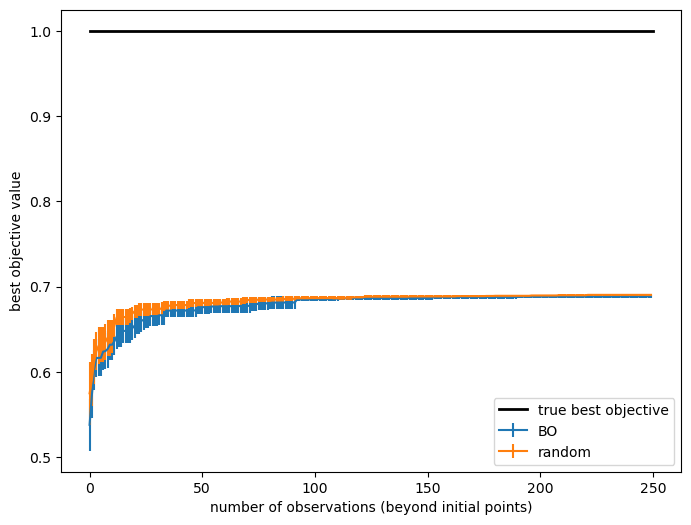

In [16]:
import numpy as np
from matplotlib import pyplot as plt


def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)

GLOBAL_MAXIMUM = 1
if USE_TEST_FUNCTION:
    GLOBAL_MAXIUM = 0



iters = np.arange(N_ITERATIONS)
y_random = np.asarray(best_random_all)
y_BO = np.asarray(best_BO_all)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.errorbar(iters, y_BO.mean(axis=0), yerr=ci(y_BO), label="BO", linewidth=1.5)
ax.errorbar(iters, y_random.mean(axis=0), yerr=ci(y_random), label="random", linewidth=1.5)
plt.plot(
    [0, N_ITERATIONS],
    [GLOBAL_MAXIMUM] * 2,
    "k",
    label="true best objective",
    linewidth=2,
)
#ax.set_ylim(bottom=0.5)
ax.set(
    xlabel="number of observations (beyond initial points)",
    ylabel="best objective value",
)
ax.legend(loc="lower right")

In [17]:
y_BO

array([[0.49088495, 0.49088495, 0.62710198, ..., 0.69571103, 0.69571103,
        0.69571103],
       [0.49549212, 0.52429136, 0.54379208, ..., 0.68497219, 0.68497219,
        0.68497219],
       [0.61664042, 0.61809832, 0.61809832, ..., 0.69066241, 0.69066241,
        0.69066241],
       ...,
       [0.55107102, 0.6785884 , 0.6785884 , ..., 0.68641052, 0.68641052,
        0.68641052],
       [0.54668306, 0.574046  , 0.59101476, ..., 0.68832295, 0.68832295,
        0.68832295],
       [0.62582083, 0.62582083, 0.62582083, ..., 0.68875957, 0.68875957,
        0.68875957]])

In [18]:
y_random

array([[0.41445319, 0.49287073, 0.51896561, ..., 0.69512266, 0.69512266,
        0.69512266],
       [0.66122514, 0.66122514, 0.66122514, ..., 0.68756997, 0.68756997,
        0.68756997],
       [0.67900408, 0.67900408, 0.67900408, ..., 0.69082378, 0.69082378,
        0.69082378],
       ...,
       [0.63046369, 0.63046369, 0.63046369, ..., 0.68936265, 0.68936265,
        0.68936265],
       [0.59949616, 0.59949616, 0.59949616, ..., 0.69013988, 0.69013988,
        0.69013988],
       [0.56369783, 0.56369783, 0.56369783, ..., 0.68677106, 0.68677106,
        0.68677106]])

In [19]:
cam.close()

In [22]:
from pylablib.devices import Thorlabs
Thorlabs.list_cameras_tlcam()
cam = Thorlabs.ThorlabsTLCamera(serial="14308")
cam.set_exposure(0.0001) # set exposure to 100ms
cam.set_roi(0,1000,0,1000) # set ROI in the upper left corner

import laserbeamsize as lbs
A0 = np.array([[random_PWM[0]], [random_PWM[1]], [random_PWM[2]], [random_PWM[3]], [random_PWM[4]]])
with open('PWM_test.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(A0)
print(f"The original PWM randomly set by {random_PWM_printed} with score {s1}")

optimal_pwm_values=best_BO_params
A1= np.array([[optimal_pwm_values[0]], [optimal_pwm_values[1]], [optimal_pwm_values[2]], [optimal_pwm_values[3]], [optimal_pwm_values[4]]])
with open('PWM_test.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(A1)
raw_image_array1 = cam.grab(10) # grab 10 frames
image_array1=np.array(raw_image_array1)
squeezed_image_array1=image_array1.squeeze()
print(f"The suggested PWM values for correction is {optimal_pwm_values} with score {best_BO_value}")
cam.close()

The original PWM randomly set by [2738, 0, 0, 0, 0] with score 0.41388363180978704
The suggested PWM values for correction is [tensor(2197.), tensor(2250.), tensor(406.), tensor(3058.), tensor(1386.)] with score 0.6887595738315464


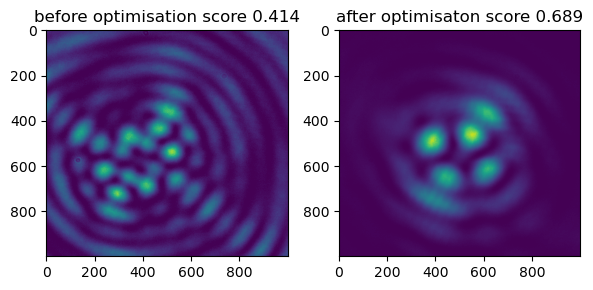

In [23]:
rows = 1
columns = 2
fig, (ax1, ax2) = plt.subplots(nrows=rows, ncols=columns, figsize=(columns*3, rows*3))
ax1.imshow(image_array_initial[0], aspect='auto')
ax1.set_title(f'before optimisation score {s1:.3f}')
ax2.imshow(image_array1[0], aspect='auto')
ax2.set_title(f'after optimisaton score {best_BO_value:.3f}')
fig.tight_layout() # used to adjust padding between subplots 

In [24]:
cam.close()

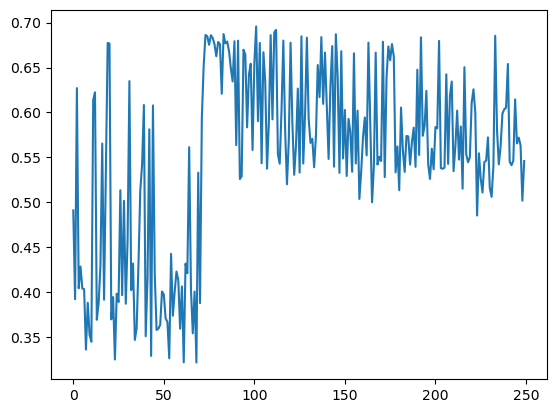

In [25]:
plt.plot(BO_trial_samples[0]["error"])